# Libs

In [34]:

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np

import os
import re
import sys

import seaborn as sns
 
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")

from WassAge import *

from pathlib import Path

# Params

In [35]:
DATA_PATH = Path("." ) / ".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid',
 'Extremal']

In [36]:
np.random.seed(1)

In [37]:
useApproxWass= False
approxStr = "Exact" if useApproxWass else "Approximate"

In [38]:
city="Quebec City"
#city="Montreal"

# Data IO

## DA shp

In [39]:
dfGeoClean = normalizeCleanDfGeo( readDAShp(city=city) )

Reading neibourhoods from Quebec City


In [40]:
dfGeoClean[LIST_AGE_COLS].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
878    1.0
879    1.0
880    1.0
881    1.0
882    1.0
Length: 879, dtype: float64

In [41]:
dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]

## Neigh

In [42]:
dfNeigh = readNeighShp(city=city)

Reading neibourhoods from Quebec City


# Dist matrix

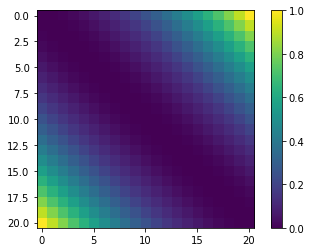

In [43]:

distMatrix = getDistanceAgeCohorts()
plt.imshow(distMatrix)
plt.colorbar()

## Compute the wasserstein barycenter for each neighbourhood

In [44]:
listWassBary=defaultdict(str)

for n in dfNeigh.NOM:
    dfSubset = dfGeoClean[dfGeoClean.NOM == n]
    listWassBary[n] = getWassBarycenter(dfSubset[LIST_AGE_COLS], distMatrix, approx=False)

Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:
Computing optimal LP sol:


## Create a df to hold the barycenters for each neigh

In [45]:
dictColNames={i : k for i,k in enumerate(LIST_AGE_COLS)} 

In [46]:
dfBarycentersNeigh = pd.DataFrame(listWassBary).T
dfBarycentersNeigh.reset_index(inplace=True)
dfBarycentersNeigh.rename(columns={"index":"NOM"} , inplace=True)
dfBarycentersNeigh.rename(columns=dictColNames, inplace=True)

dfBarycentersNeigh.head()

NOM       0_4       5_9     10_14  \
0                           Saint-Jean-Baptiste  0.021386  0.024494  0.021365   
1                                     Cap-Rouge  0.045079  0.053319  0.053907   
2                            Cité Universitaire  0.018000  0.026390  0.041362   
3  Vieux-Québec/Cap-Blanc/Colline parlementaire  0.010000  0.015641  0.009757   
4                                   Des Châtels  0.057851  0.053866  0.049746   

      15_19     20_24     25_29     30_34     35_39     40_44  ...     55_59  \
0  0.022560  0.048828  0.078723  0.124507  0.122358  0.086107  ...  0.074604   
1  0.065691  0.052133  0.051654  0.043541  0.049965  0.056352  ...  0.107895   
2  0.050952  0.099747  0.119371  0.085854  0.071089  0.070939  ...  0.055966   
3  0.026549  0.046386  0.071667  0.067788  0.078528  0.073684  ...  0.104869   
4  0.067109  0.056749  0.057520  0.059084  0.063700  0.065177  ...  0.091637   

      60_64     65_69     70_74     75_79     80_84         85_89  \
0  0.066038  0.068172  0.048635  0.030191  0.013685  9.128426e-03   
1  0.100837  0.091683  0.051167  0.020309  0.010857  5.489153e-03   
2  0.054362  0.049273  0.044295  0.028958  0.017397  9.676206e-03   
3  0.098039  0.075294  0.065405  0.052928  0.026961  1.470588e-02   
4  0.069379  0.070911  0.044553  0.022126  0.015152  2.354030e-08   

          90_94         95_99         100_+  
0  5.964604e-10  1.737285e-10  8.058070e-11  
1  9.656454e-13  3.733234e-13  1.846782e-13  
2  5.240466e-03  7.597949e-11  3.078064e-11  
3  1.275707e-10  3.138833e-11  1.311898e-11  
4  5.350921e-09  2.351334e-09  1.197330e-09  

[5 rows x 22 columns]

## Now compute the overall barycenter (neighbourhood level)

In [47]:
wassBaryGlobal = getWassBarycenter(dfBarycentersNeigh[LIST_AGE_COLS], distMatrix, approx=False)

Computing optimal LP sol:


## Get the wass distance (using ground L2 metric so this is earth mover) between overall barycenter and neigh barycenters

In [48]:
listOptTransNeigh=defaultdict(str)
listCostsNeigh=defaultdict(str)

for n in dfBarycentersNeigh.NOM: 
    idxNeigh = dfBarycentersNeigh.NOM == n
    listOptTransNeigh[n] = ot.emd(wassBaryGlobal,
                      np.ascontiguousarray(dfBarycentersNeigh[idxNeigh][LIST_AGE_COLS].T.values).ravel(),  #this needs to be an array with shape (21,) - there are 21 age cohorts
                      distMatrix)
    listCostsNeigh[n] = np.sum( listOptTransNeigh[n][:] * distMatrix[:])
 


### Reorder by distance to barycenter

In [49]:
dfBarycentersNeigh["distToBarycenter"] = list(listCostsNeigh.values())
dfBarycentersNeigh.sort_values("distToBarycenter", inplace=True)
dfBarycentersNeigh.NOM=pd.Categorical( dfBarycentersNeigh.NOM, categories=[n for n in dfBarycentersNeigh.NOM],ordered=True)
dfBarycentersNeigh.head()

NOM       0_4       5_9     10_14     15_19  \
13  Neufchâtel-Est/Lebourgneuf  0.037162  0.039761  0.047133  0.046548   
10                Loretteville  0.048780  0.046589  0.045474  0.042430   
25          Chutes-Montmorency  0.037976  0.043657  0.041479  0.052443   
8                       Lairet  0.044776  0.030224  0.032692  0.038649   
5          Duberger-Les Saules  0.049147  0.044252  0.040162  0.054150   

       20_24     25_29     30_34     35_39     40_44  ...     60_64     65_69  \
13  0.051619  0.067633  0.062663  0.067482  0.068189  ...  0.093933  0.080670   
10  0.067219  0.053012  0.065790  0.069745  0.062878  ...  0.074325  0.073848   
25  0.066177  0.057713  0.056750  0.052619  0.063198  ...  0.094919  0.081498   
8   0.074970  0.084811  0.082227  0.065497  0.058349  ...  0.080599  0.066479   
5   0.065882  0.067080  0.068197  0.065849  0.065845  ...  0.070294  0.061990   

       70_74     75_79     80_84     85_89         90_94         95_99  \
13  0.052288  0.034669  0.016281  0.007874  1.844370e-09  6.449000e-10   
10  0.060732  0.042249  0.019543  0.013358  1.188699e-11  1.791530e-12   
25  0.049349  0.033942  0.021649  0.011428  2.366685e-11  6.804107e-12   
8   0.052789  0.038462  0.028402  0.017751  1.673153e-08  9.172529e-10   
5   0.055120  0.039032  0.021471  0.011323  6.550162e-11  1.907155e-11   

           100_+  distToBarycenter  
13  3.230598e-10          0.000384  
10  8.022163e-13          0.000385  
25  3.189770e-12          0.000472  
8   3.828002e-10          0.000538  
5   9.196961e-12          0.000574  

[5 rows x 23 columns]

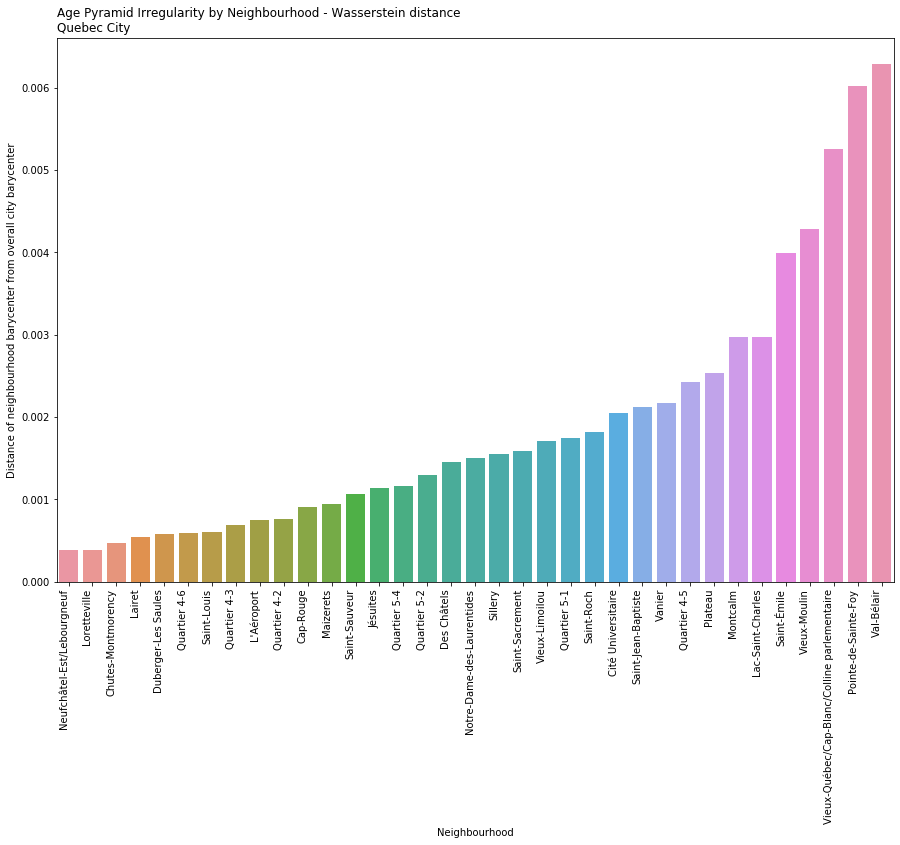

In [50]:
f=plt.figure(figsize=(15,10))


ax=sns.barplot(x="NOM" , y = "distToBarycenter" , data=dfBarycentersNeigh, order=dfBarycentersNeigh["NOM"]) 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set(xlabel="Neighbourhood", 
       ylabel="Distance of neighbourhood barycenter from overall city barycenter"
       )
_= plt.title(label=f"Age Pyramid Irregularity by Neighbourhood - Wasserstein distance\n{city}", loc="left")

f.savefig( DATA_PATH /".."/ "Figures" / "ByNeigh" / f"wassBarPlotByNeigh_{city}.png") 

## Plot the neighbouhood barycenters

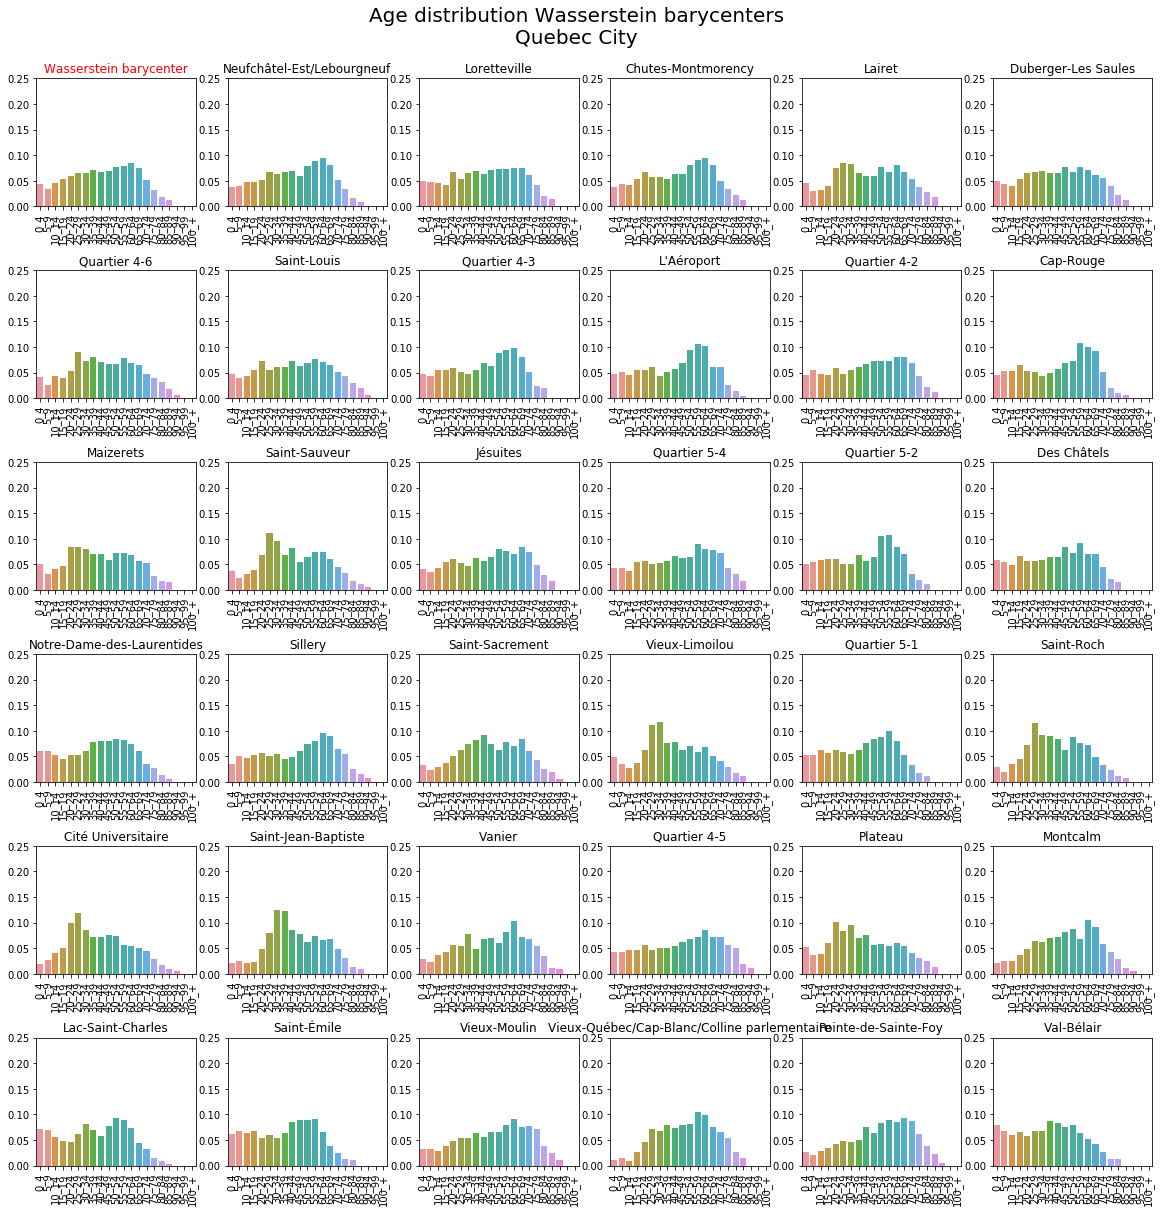

In [51]:
f=plt.figure(figsize=(20,20))
maxY=0.25

    
#The barycenter
sp=plt.subplot(6,6,1)
ax=sns.barplot(  x=LIST_AGE_COLS, y= wassBaryGlobal )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title(label="Wasserstein barycenter", fontname="DejaVu Sans",color="red")
plt.ylim(0,maxY)

    
#Now the rest of the neighourhoods
for k,n in enumerate(dfBarycentersNeigh["NOM"].unique().sort_values()):
    dfSubset = dfBarycentersNeigh.loc[dfBarycentersNeigh["NOM"] == n,]
    sp=plt.subplot(6,6,k+1+1)
    ax=sns.barplot(  x=LIST_AGE_COLS, y= dfSubset[LIST_AGE_COLS].mean()  )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(label=f"{n}")
    plt.ylim(0,maxY)



plt.subplots_adjust(hspace=0.5)
_ = plt.suptitle(f"Age distribution Wasserstein barycenters\n{city}", fontsize=20 , y=0.93, x=0.5)


f.savefig( DATA_PATH /".."/ "Figures" / "ByNeigh" / f"wassAgePyramidBarycenterByNeigh_{city}.png") 